# Messing around with location history

In [1]:
#!pip install HASS-data-detective # Install detective

In [2]:
# !pip install plotly chart-studio swifter

In [3]:
# !pip show HASS-data-detective

In [4]:
import detective.core as detective
import detective.functions as functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import swifter

db = detective.db_from_hass_config(fetch_entities=False)

YAML tag !include_dir_merge_list is not supported
YAML tag !include_dir_merge_named is not supported
Successfully connected to database sqlite:////config/home-assistant_v2.db


First we extract all state changes for Gaby and Charles

In [5]:
people = ("person.charles","person.gaby",)

In [6]:
# Copied from HASS-data-detective and modified to join the new attributes table
sensors_str = str(tuple(people))
if len(people) == 1:
    sensors_str = sensors_str.replace(",", "")

query = f"""
    SELECT domain, entity_id, state, last_updated, shared_attrs
    FROM states
    LEFT JOIN state_attributes ON states.attributes_id = state_attributes.attributes_id
    WHERE
        entity_id IN {sensors_str}
    AND
        state NOT IN ('unknown', 'unavailable')
    ORDER BY last_changed DESC
    """

results = pd.read_sql_query(query, db.url)
print(f"{len(results)} results loaded")
results

39610 results loaded


,domain,entity_id,state,last_updated,shared_attrs
0,None,person.gaby,home,2022-10-14 21:50:50.483046,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
1,None,person.gaby,home,2022-10-14 21:52:41.636371,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
2,None,person.gaby,home,2022-10-14 21:57:29.491531,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
3,None,person.gaby,home,2022-10-14 21:58:46.692523,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
4,None,person.gaby,home,2022-10-14 22:03:10.687805,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
...,...,...,...,...,...
39605,None,person.gaby,home,2022-05-06 06:43:22.576767,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
39606,None,person.gaby,home,2022-05-06 06:46:22.767125,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
39607,None,person.gaby,home,2022-05-06 06:47:16.641555,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
39608,None,person.gaby,home,2022-05-06 06:47:34.924815,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."


In [7]:
results.last_changed = pd.to_datetime(results["last_updated"])
results.set_index('last_updated', inplace=True)
results.index.rename("time", inplace=True)
results.sort_index(inplace=True)
results

/tmp/ipykernel_835/2555479191.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  results.last_changed = pd.to_datetime(results["last_updated"])


,domain,entity_id,state,shared_attrs
time,,,,
2022-05-06 03:15:07.110833,None,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
2022-05-06 03:20:23.946649,None,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
2022-05-06 03:24:58.453512,None,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
2022-05-06 03:30:02.878928,None,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
2022-05-06 03:38:07.624507,None,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
...,...,...,...,...
2022-10-15 15:27:32.331339,None,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
2022-10-15 15:30:02.921133,None,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
2022-10-15 15:30:55.197048,None,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."


In [8]:
import yaml
l = lambda s : yaml.safe_load(s)
results["parsed_attrs"] = results.loc[:, "shared_attrs"].swifter.apply(l)

Pandas Apply:   0%|          | 0/39610 [00:00<?, ?it/s]

In [9]:
results['latitude'] = results['parsed_attrs'].apply(lambda i : i['latitude'])
results['longitude'] = results['parsed_attrs'].apply(lambda i : i['longitude'])

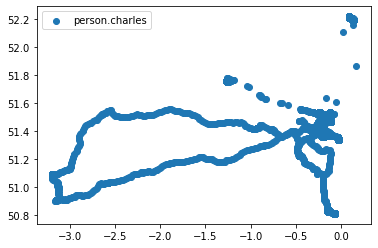

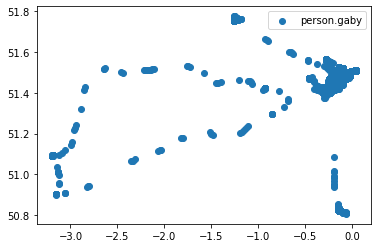

In [10]:
import matplotlib.pyplot as plt

for person in people:
    plt.figure()
    k = (results["entity_id"] == person) & (results["longitude"] > -20)
    plt.scatter(results.loc[k, 'longitude'], results.loc[k, 'latitude'])
    plt.legend([person])
# results.plot.scatter(x="longitude", y="latitude", alpha=0.4, label="entity_id");

In [11]:
out = results.loc[:,['entity_id', 'latitude', 'longitude']]
out

,entity_id,latitude,longitude
time,,,
2022-05-06 03:15:07.110833,person.gaby,51.409610,-0.280304
2022-05-06 03:20:23.946649,person.gaby,51.409616,-0.280316
2022-05-06 03:24:58.453512,person.gaby,51.409622,-0.280314
2022-05-06 03:30:02.878928,person.gaby,51.409595,-0.280277
2022-05-06 03:38:07.624507,person.gaby,51.409629,-0.280312
...,...,...,...
2022-10-15 15:27:32.331339,person.gaby,51.409752,-0.280121
2022-10-15 15:30:02.921133,person.gaby,51.409740,-0.280107
2022-10-15 15:30:55.197048,person.gaby,51.409735,-0.280114


In [12]:
out.to_csv("locations.csv")

In [13]:
pd.read_csv("locations.csv")

,time,entity_id,latitude,longitude
0,2022-05-06 03:15:07.110833,person.gaby,51.409610,-0.280304
1,2022-05-06 03:20:23.946649,person.gaby,51.409616,-0.280316
2,2022-05-06 03:24:58.453512,person.gaby,51.409622,-0.280314
3,2022-05-06 03:30:02.878928,person.gaby,51.409595,-0.280277
4,2022-05-06 03:38:07.624507,person.gaby,51.409629,-0.280312
...,...,...,...,...
39605,2022-10-15 15:27:32.331339,person.gaby,51.409752,-0.280121
39606,2022-10-15 15:30:02.921133,person.gaby,51.409740,-0.280107
39607,2022-10-15 15:30:55.197048,person.gaby,51.409735,-0.280114
39608,2022-10-15 15:31:02.339909,person.gaby,51.409742,-0.280226


In [14]:
# import plotly
# import chart_studio.plotly as py
# import plotly.graph_objs as go
# plotly.offline.init_notebook_mode()

# coords = pd.concat([results['latitude'], results['longitude']], axis=1)
# coords = coords.sample(frac=0.1, replace=True)

# colors = ['rgb(239,243,255)','rgb(189,215,231)','rgb(107,174,214)','rgb(33,113,181)']

# points = go.Scattergeo(
#     lon = coords['longitude'],
#     lat = coords['latitude']
# )


# layout = go.Layout(
#     title = 'Hey look! It\'s a scatter plot on a map!',
#     geo = dict(
#         # resolution = 110,
#         scope = 'europe',
#         # showframe = True,
#         # showcoastlines = True,
#         # showland = True,
#         # landcolor = "rgb(229, 229, 229)",
#         # countrycolor = "rgb(255, 255, 255)" ,
#         # coastlinecolor = "rgb(255, 255, 255)",
#         # projection = dict(
#         #     type = 'mercator'
#         # ),
#         # lonaxis = dict( range= [ -124.0, -113.0 ] ),
#         # lataxis = dict( range= [ 32.0, 43.0 ] ),
        
#     ),
#     legend = dict(
#            traceorder = 'reversed'
#     )
# )


# fig = go.Figure(layout=layout, data=points)
# plotly.offline.iplot(fig, validate=False)

In [15]:
# import plotly.express as px
# df = px.data.gapminder().query("year == 2007")
# fig = px.scatter_geo(df, locations="iso_alpha",
#                      size="pop", # size of markers, "pop" is one of the columns of gapminder
#                      )
# fig.show()

In [16]:
# coords

In [17]:
# k = results["longitude"] > -20
# filtered_results = results.loc[k, :]

# import plotly.express as px


# fig = px.scatter_geo(filtered_results, lat="latitude", lon="longitude", scope="europe")
# fig.show()